# 🍫Tune your RAG data pipeline and evaluate its performance

> ⚠️ This notebook can be run on your local machine or on a virtual machine and requires [Docker Compose](https://docs.docker.com/desktop/).
> Please note that it is unfortunately **not compatible with Google Colab** as the latter does not support Docker.

> 💡 This notebook allows you to iteratively configure and run a RAG pipeline. Check out our [advanced notebook](./parameter_search.ipynb) if you want to perform parameter search and launch multiple runs at once.

In this notebook we demonstrate how to iteratively evaluate and tune a Retrieval-Augmented Generation (RAG) system using [Fondant](https://fondant.ai).

We will:

1. Set up a [Weaviate](https://weaviate.io/platform) vector store
2. Define a parameter set to test
3. Run a Fondant pipeline with those parameters to index our documents into the vector store
4. Run a Fondant pipeline with those parameters to evaluate the performance
5. Inspect the evaluation results and data between each processing step
6. Repeat step 2 - 5 until we're happy with the results

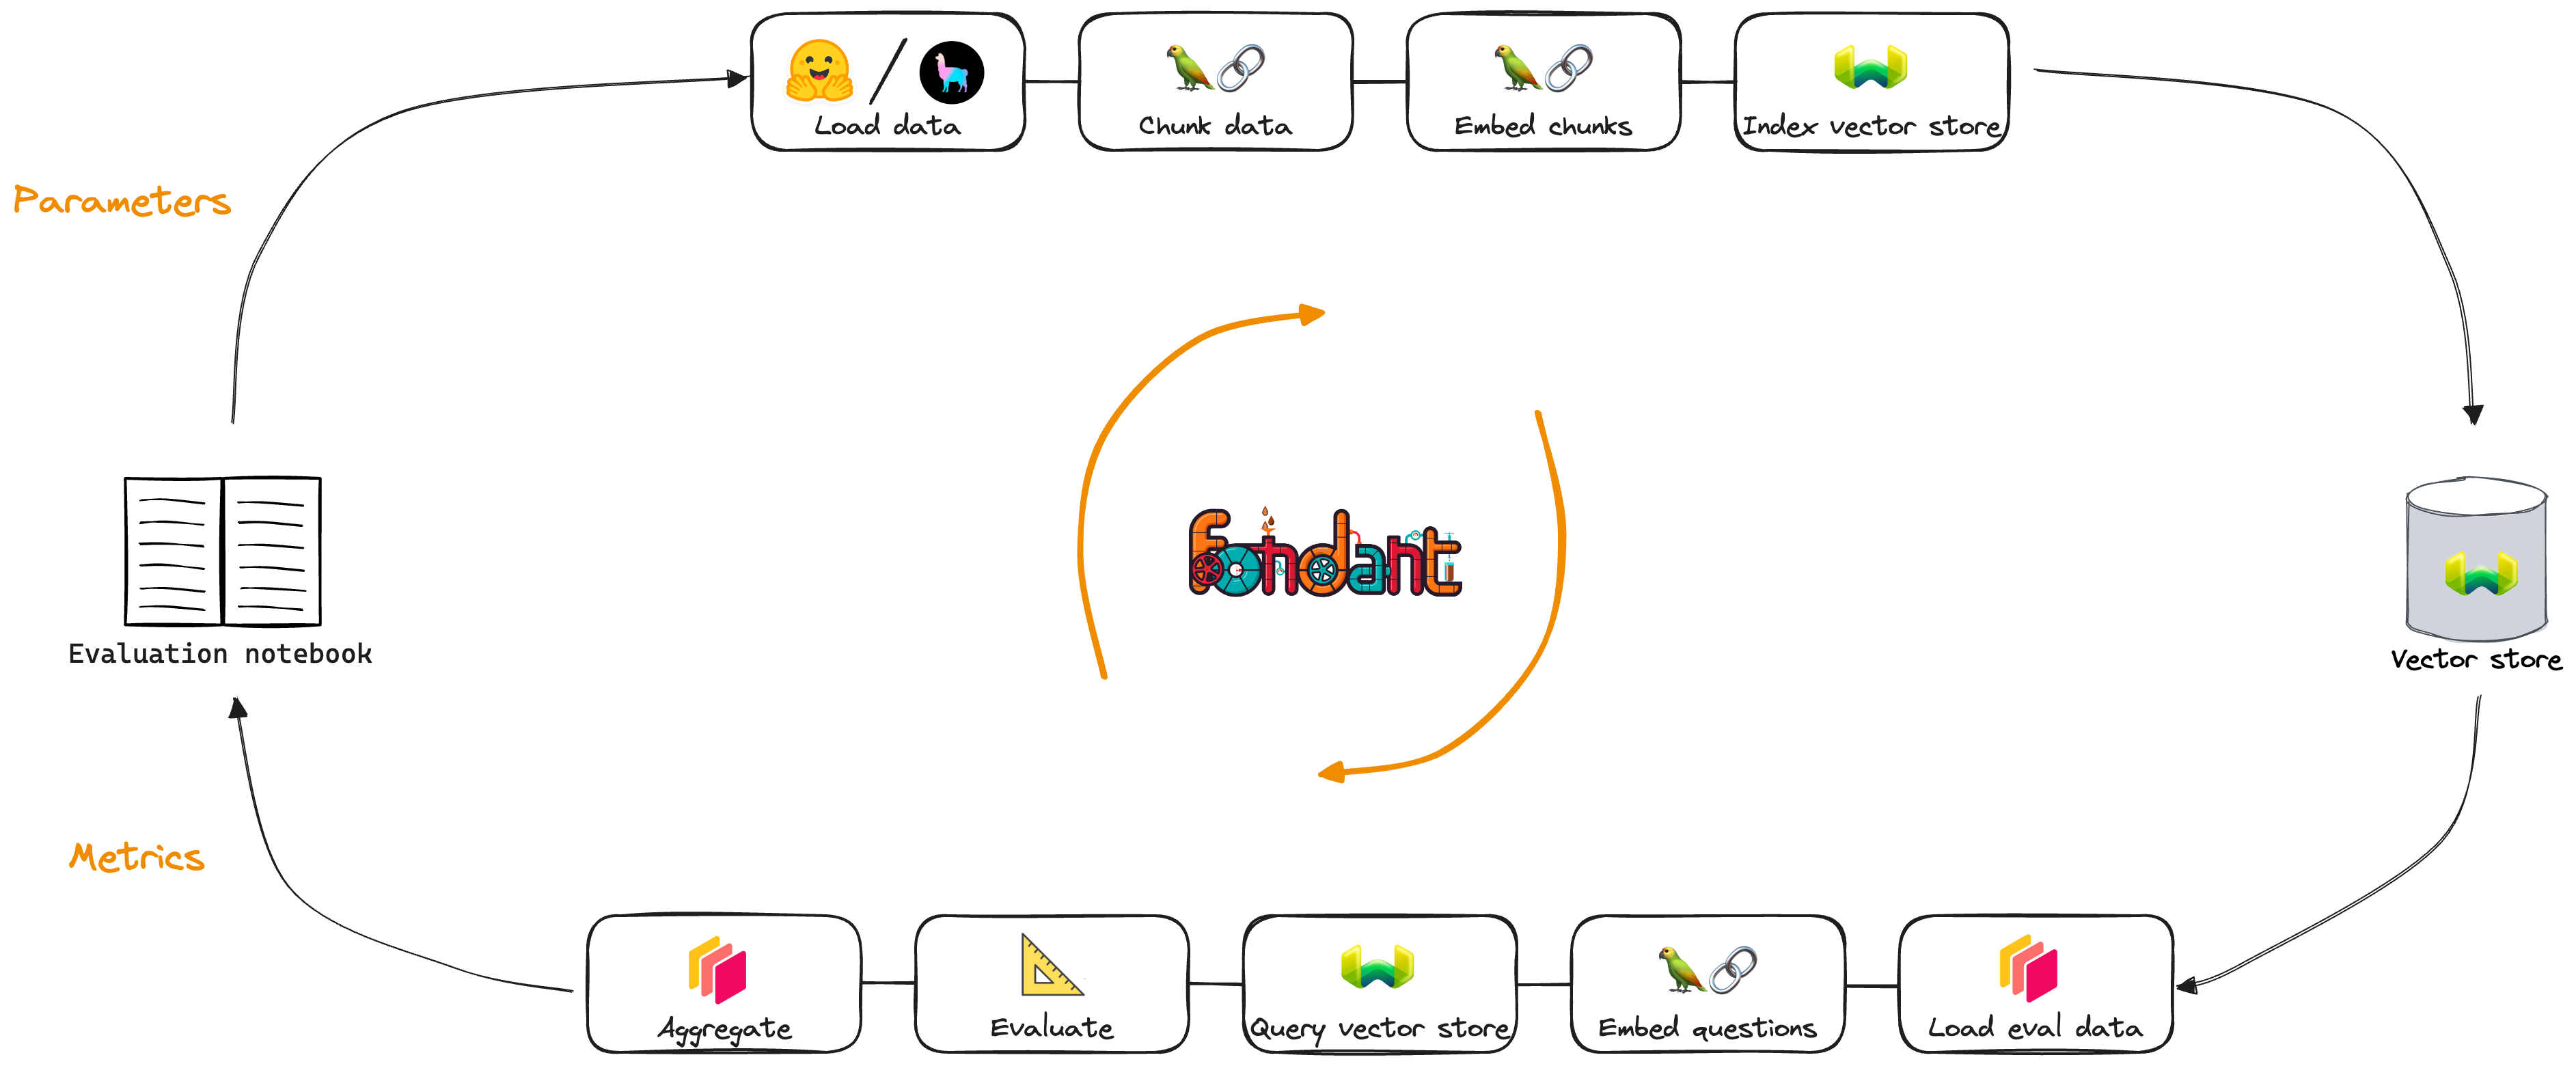

We will use [**Fondant**](https://github.com/ml6team/fondant), a hub and framework for easy and shareable data processing, as it has the following advantages for RAG evaluation:

- **Speed**
    - Leverage reusable RAG components from the [Fondant Hub](https://fondant.ai/en/latest/components/hub/) to quickly build RAG pipelines
    - [Pipeline caching](https://fondant.ai/en/latest/caching/) to speed up iteration on subsequent runs
    - Parallel processing out of the box to speed up processing of large datasets especially
    - Local development with the Docker Compose runner (used in this notebook)
- **Ease-of-use**
    - Easily adaptable: change parameters and swap [components](https://fondant.ai/en/latest/components/hub/) by changing only a few lines of code
    - Easily extendable: create your own [custom components](https://fondant.ai/en/latest/components/custom_component/) (eg. with different chunking strategies) and plug them into your pipeline
    - Reusable & shareable: reuse your processing components in different pipelines and share them with the [community](https://discord.gg/HnTdWhydGp)
- **Production-readiness**
    - Pipeline with dockerized steps ready to deploy to (managed) platforms such as _Vertex, SageMaker and Kubeflow_
    - Full data lineage and a [data explorer](https://fondant.ai/en/latest/data_explorer/) to check the evolution of data after each step
    - Ready to deploy to (managed) platforms such as _Vertex, SageMaker and Kubeflow_
 
Please share your experiences or let us know how we can improve through our [**Discord**](https://discord.gg/HnTdWhydGp) or on [**GitHub**](https://github.com/ml6team/fondant). And of course feel free to give us a [**star ⭐**](https://github.com/ml6team/fondant) if you like what we are doing!


## Set up environment

> ⚠️ This section checks the prerequisites of your environment. Read any errors or warnings carefully.

Ensure a Python between version 3.8 and 3.10 is available

In [ ]:
import sys
if sys.version_info < (3, 8, 0) or sys.version_info >= (3, 11, 0):
    raise Exception(f"A Python version between 3.8 and 3.10 is required. You are running {sys.version}")

Check if docker compose is installed and the docker daemon is running

In [ ]:
!docker compose version

**Check if GPU is available**

In [ ]:
import logging
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    logging.info("Found GPU, using it!")
    number_of_accelerators = 1
    accelerator_name = "GPU"
except Exception:
    logging.warning("We recommend to run this pipeline on a GPU, but none could be found, using CPU instead")
    number_of_accelerators = None
    accelerator_name = None

Install Fondant

In [ ]:
!pip install -q -r ../requirements.txt --disable-pip-version-check && echo "Success"

## Spin up the Weaviate vector store

> ⚠️ For Apple M1/M2 chip users:
> 
> - In Docker Desktop Dashboard `Settings -> Features in development`, make sure to **un**check `Use containerd` for pulling and storing images. More info [here](https://docs.docker.com/desktop/settings/mac/#beta-features)
> - Make sure that Docker uses linux/amd64 platform and not arm64 (cell below should take care of that)

In [ ]:
import os
os.environ["DOCKER_DEFAULT_PLATFORM"]="linux/amd64"

Run Weaviate with Docker compose

In [ ]:
!docker compose -f weaviate/docker-compose.yaml up --detach

Make sure you have Weaviate client v3

In [ ]:
!pip install -q "weaviate-client==3.*" --disable-pip-version-check && echo "Weaviate client installed successfully"

Make sure the vectorDB is running and accessible

In [ ]:
import logging
import weaviate

try:
    local_weaviate_client = weaviate.Client("http://localhost:8081")
    logging.info("Connected to Weaviate instance")
except weaviate.WeaviateStartUpError:
    logging.error("Cannot connect to weaviate instance, is it running?")

## Indexing pipeline

This pipeline, which can be found in [`pipeline_index.py`](./pipeline_index.py) processes text data and loads it into the vector database. It consists of the following steps:

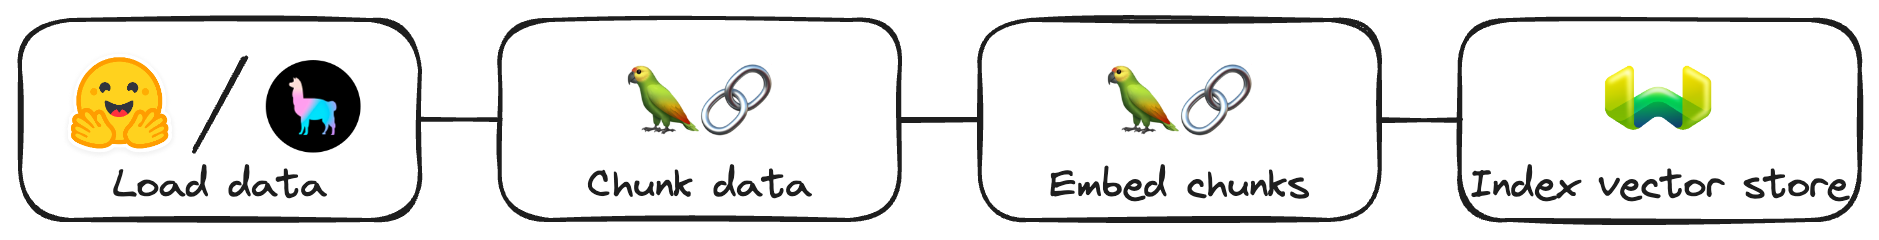

- [**HF Data Loading**](https://github.com/ml6team/fondant/tree/main/components/load_from_parquet): loads data from the Hugging Face Hub.
- [**Text Chunking**](https://github.com/ml6team/fondant/tree/main/components/chunk_text): divides the text into sections of a certain size and with a certain overlap
- [**Text Embedding**](https://github.com/ml6team/fondant/tree/main/components/embed_text): embeds each chunk as a vector.  
  💡 Can use different models / APIs. When using a HuggingFace model (the default), use a machine with GPU for large datasets.
- [**Write to Weaviate**](https://github.com/ml6team/fondant/tree/main/components/index_weaviate): writes data and embeddings to the vector store

> 💡 This notebook defaults to the first 1000 rows of the [wikitext](https://huggingface.co/datasets/wikitext) dataset for demonstration purposes, but you can load your own dataset using one the other load components available on the [**Fondant Hub**](https://fondant.ai/en/latest/components/hub/#component-hub) or by creating your own [**custom load component**](https://fondant.ai/en/latest/guides/implement_custom_components/). Keep in mind that changing the dataset implies that you also need to change the evaluation dataset used in the evaluation pipeline. 

#### Create the indexing pipeline

Change the arguments below if you want to run the pipeline with different parameters. For more information on the possible values, check out the above links to the component documentation.

In [ ]:
import pipeline_index
import utils

# Path where data and artifacts will be stored
BASE_PATH = "./data-dir"
utils.create_directory_if_not_exists(BASE_PATH)

# Parameters shared between indexing and evaluation pipeline
shared_args = {
    "base_path": BASE_PATH,
    "embed_model_provider": "huggingface",
    "embed_model": "all-MiniLM-L6-v2",
    "embed_api_key": {},
    "weaviate_url": f"http://{utils.get_host_ip()}:8081",
    "weaviate_class": "Pipeline1", # Capitalized, avoid special characters (_, =, -, etc.)
}

# Parameters for the indexing pipeline
indexing_args = {
    "n_rows_to_load": 1000,
    "chunk_size": 1024,
    "chunk_overlap": 8,
}

# Parameters for the indexing pipeline
resources_args = {
    "number_of_accelerators": number_of_accelerators,
    "accelerator_name": accelerator_name,
}

indexing_pipeline = pipeline_index.create_pipeline(**shared_args, **indexing_args, **resources_args)

#### Run the indexing pipeline

> 💡 The first time you run a pipeline, you need to download a docker image for each component which may take a minute. The second time, processing will start instantly. Moreover, steps that have been processed before are cached and will be skipped in subsequent runs which will speed things up even further.

In [ ]:
from fondant.pipeline.runner import DockerRunner

runner = DockerRunner()
runner.run(indexing_pipeline)

## Evaluation Pipeline

This pipeline, which can be found in `pipeline_eval.py` evaluates retrieval performance using the questions provided in your test dataset. It consists of multiple steps/components:

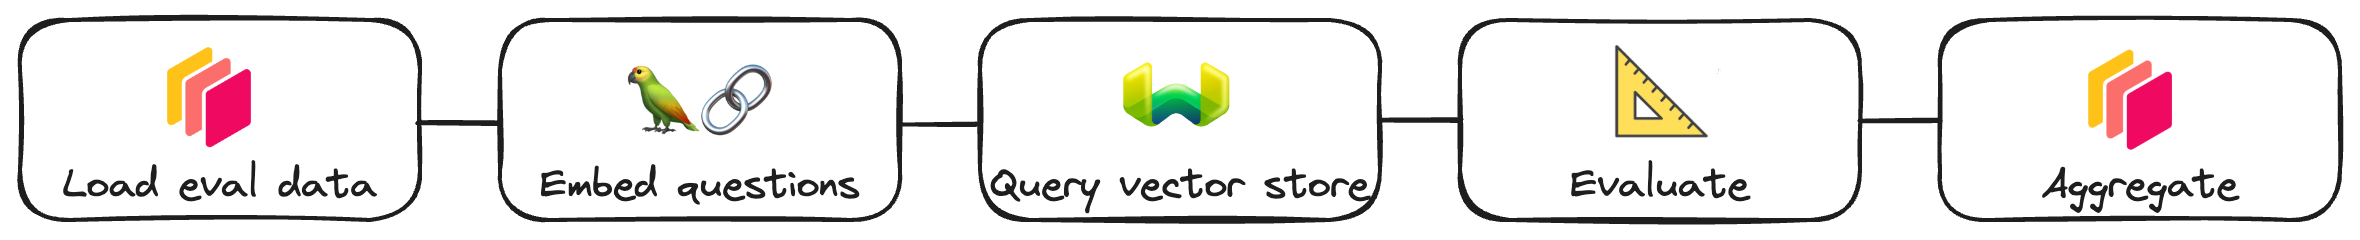

- [**CSV Data Loading**](https://github.com/ml6team/fondant/tree/main/components/load_from_csv): loads the evaluation dataset (questions) from a csv file.
- [**Text Embedding**](https://github.com/ml6team/fondant/tree/main/components/embed_text): embeds each chunk as a vector.  
  💡 Can use different models / APIs. When using a HuggingFace model (the default), use a machine with GPU for large datasets.
- [**Vector store Retrieval**](https://github.com/ml6team/fondant/tree/main/components/retrieve_from_weaviate): retrieves the most relevant chunks for each question from the vector store.
- [**Ragas evaluation**](https://github.com/ml6team/fondant/tree/0.8.0/components/evaluate_ragas): evaluates the retrieved chunks for each question with [RAGAS](https://docs.ragas.io/en/latest/index.html).
- [**Aggregate metrics**](https://github.com/ml6team/fondant-usecase-RAG/tree/main/src/components/aggregate_eval_results): Aggregate the results on a pipeline level.

### Create the evaluation pipeline

⚠️ If you want to use OpenAI you will need an [OpenAI API key](https://platform.openai.com/docs/quickstart) (see TODO below)

Change the arguments below if you want to run the pipeline with different parameters.

In [ ]:
import os
import pipeline_eval

evaluation_args = {
    "retrieval_top_k": 2,
    "evaluation_module": "langchain.llms",
    "evaluation_llm": "OpenAI",
    "evaluation_llm_kwargs": {"openai_api_key": os.environ["OPENAI_KEY"], "model_name" : "gpt-3.5-turbo"},  # TODO: Update with your key or use a different model
    "evaluation_metrics": ["context_precision", "context_relevancy"]
}

evaluation_pipeline = pipeline_eval.create_pipeline(**shared_args, **evaluation_args, **resources_args)

#### Run the evaluation pipeline

In [ ]:
runner = DockerRunner()
extra_volumes = [str(os.path.join(os.path.abspath('.'), "evaluation_datasets")) + ":/data"]
runner.run(evaluation_pipeline, extra_volumes=extra_volumes)

utils.store_results(evaluation_pipeline.name, **shared_args, **indexing_args)

#### Show evaluation results

In [ ]:
utils.read_results(evaluation_pipeline.name, base_path=BASE_PATH)

## Explore data

You can also check your data and results at each step in the pipelines using the Fondant data explorer. The first time you run the data explorer, you need to download the docker image which may take a minute. Afterwards you can access the data explorer at:

**http://localhost:8501/**

Enjoy the exploration! 🍫 

Press the ◼️ in the notebook toolbar to stop the explorer.

In [ ]:
from fondant.explore import run_explorer_app

run_explorer_app(base_path=BASE_PATH)

## Clean up your environment

After your pipeline ran successfully, you should clean up your environment and stop the weaviate database.

In [ ]:
!docker compose -f weaviate/docker-compose.yaml down

## Feedback

Please share your experience or let us know how we can improve through our 
* [**Discord**](https://discord.gg/HnTdWhydGp) 
* [**GitHub**](https://github.com/ml6team/fondant)

And of course feel free to give us a [**star** ⭐](https://github.com/ml6team/fondant) if you like what we are doing!